In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from tqdm.notebook import tqdm
from pupil_import import * # THIS IMPORTS NUMPY AS NP FFS
from copy import deepcopy
import pickle

In [2]:
import jax
import jax.numpy as np
import numpy as onp
from jax import grad, jacfwd, jacrev, jit, value_and_grad
from jax.ops import index, index_add, index_update

In [3]:
# RUN TO ENABLE DEFAULT 64 BIT DATA TYPES
# MUST BE RUN AT START OF NOTEBOOK!!

# from jax.config import config
# config.update("jax_enable_x64", True)

In [4]:
def JAX_model(x, y, args=None):
    pupil = args['pupil']
    aperture = args['aperture']
    npix = args['npix']
    wl = args['wl']
    fl = args['fl']
    pix_size = args['pix_size']
    tf_size = args['tf_size']

    # Calcualtions
    size_out = args['size']
    phase_scale = 2 * np.pi * aperture * pix_size / fl
    fact = tf_size/size_out
    c = tf_size//2
    s = npix//2
    
    # Off axis stars, create phase slope
    r_pix = np.hypot(x, y) # Distance from off axis (pixels)
    phi_rot = np.arctan2(y, x) # Coordiante rotation angle
    delta_phase = phase_scale * r_pix / wl # Change in phase across the aperture
    eps = 0.0001
    phase_slope = np.linspace(eps, delta_phase + eps, size_out, endpoint=False)
    Xs, Ys  = np.meshgrid(phase_slope, phase_slope)
    Rs = np.hypot(Xs, Ys)
    Phis = np.arctan2(Ys, Xs)
    phase_out = Rs * np.cos(Phis + phi_rot)
    
    # Add phase to pupil
    pupil_phase = np.angle(pupil) + phase_out    
    pupil_mag = np.abs(pupil)
    pupil_new = pupil_mag * np.exp(1j * (pupil_phase))    
    
#     FOR FLOAT 32
    array_out = np.zeros((tf_size,tf_size),dtype=np.complex64)
#     # FOR FLOAT 64
#     array_out = np.zeros((tf_size,tf_size),dtype=np.complex128)
    
    array_out = index_update(array_out, index[0:size_out, 0:size_out], pupil_new)

    # Perform FT
    wf = np.fft.fftshift(np.fft.fft2(array_out))
    PSF = np.abs(wf)**2
    PSF_norm = PSF/np.sum(PSF)    
    PSF_out = PSF_norm[c-s:c+s, c-s:c+s]

    return PSF_out

In [5]:
# Define simulation parameters
aperture = 0.018 # 18mm
wl = 525e-9 # 525nm - Central green band on RBP cam
fl = 0.15 # 15cm camera lens
npix = 256 # Only simulate central region
pix_size = 1.12e-6 # 1.12 microns
tf_size = 2**9

In [6]:
pupil_in = pupil_from_fits("pupil.fits")
plate_scale = pix_size/fl    # Radians per pixel
spatial_freq = wl/aperture
scale_factor = spatial_freq/plate_scale
size_out = int(tf_size/scale_factor)
print(size_out)
pupil = scale_pupil(pupil_in, size_out)
np.save("pupil.npy", pupil)

131


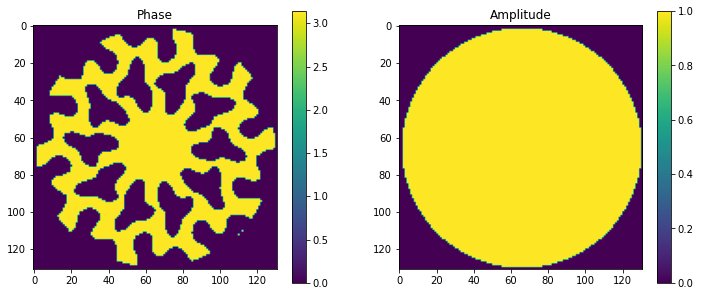

In [68]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.imshow(np.angle(pupil))
plt.colorbar()
plt.title("Phase")

plt.subplot(1, 2, 2)
plt.imshow(np.abs(pupil))
plt.colorbar()
plt.title("Amplitude")

plt.show()

In [69]:
padded_pupil = index_update(np.zeros([tf_size, tf_size]), index[0:size_out, 0:size_out], pupil)

/suphys/ldes9555/anaconda3/envs/main/lib/python3.8/site-packages/jax/ops/scatter.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax.convert_element_type(out, dtype)


In [70]:
args = {
    'image': None,
    'pupil': pupil,
    'aperture': aperture,
    'npix': npix,
    'wl': wl,
    'fl': fl,
    'pix_size': pix_size,
    'tf_size': tf_size,
    'size': size_out,
}

PSF = JAX_model(0, 0, args=args)
OTF = np.abs(np.fft.fftshift(np.fft.fft2(PSF)))

In [ ]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.imshow(PSF)
plt.title("New PSF")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(OTF)
plt.title("New OTF")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.log10(OTF))
plt.title("New OTF (log10)")
plt.colorbar()

plt.show()

---

## Method 1: Use super-gaussian to zero power outside the 'OTF' in the image plane

In [49]:
im_plane = np.fft.fftshift(np.fft.fft2(padded_pupil))

In [50]:
x0 = 0
y0 = 0
sigma = 70
power = 10

c = tf_size/2
xs = np.linspace(-c-x0, c-x0, tf_size, endpoint=False)
ys = np.linspace(-c+y0, c+y0, tf_size, endpoint=False)
X, Y = np.meshgrid(xs, ys)
exponent = ((X)**2/(2*sigma**2) + (Y)**2/(2*sigma**2))**power
OTF_filter = np.exp(-exponent)

# OTF_filter_shifted = np.fft.fftshift(OTF_filter)

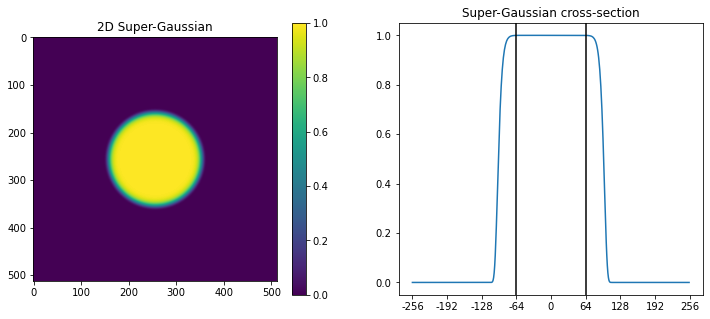

In [51]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.imshow(OTF_filter)
plt.title("2D Super-Gaussian")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(OTF_filter[:, int(c)])
plt.title("Super-Gaussian cross-section")
xticks = np.arange(0, tf_size+1, 64)
xtick_vals = np.arange(-c, c+1, 64).astype(np.int16)
plt.xticks(xticks, xtick_vals)
plt.axvline( 65+c, c='k')
plt.axvline(-65+c, c='k')
plt.show()


### Now we multiply the image plane by the filter

In [52]:
# im_plane_filtered = im_plane * OTF_filter_shifted
im_plane_filtered = im_plane * OTF_filter

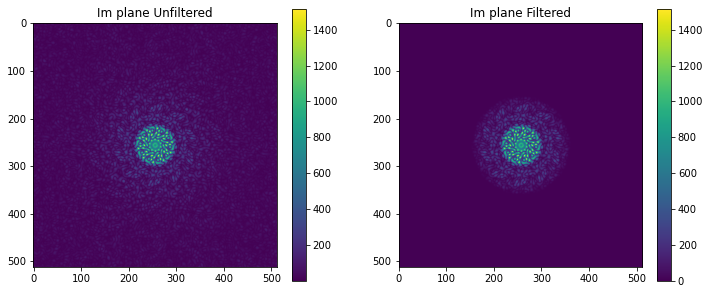

In [55]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
# plt.imshow(np.abs(np.fft.fftshift(im_plane)))
plt.imshow(np.abs(im_plane))
plt.colorbar()
plt.title("Im plane Unfiltered")

plt.subplot(1, 2, 2)
# plt.imshow(np.abs(np.fft.fftshift(im_plane_filtered)))
plt.imshow(np.abs(im_plane_filtered))
plt.colorbar()
plt.title("Im plane Filtered")

plt.show()

### Now we inverse FT to return to pupil plane

In [56]:
pupil_smooth = np.fft.ifft2(np.fft.fftshift(im_plane_filtered))

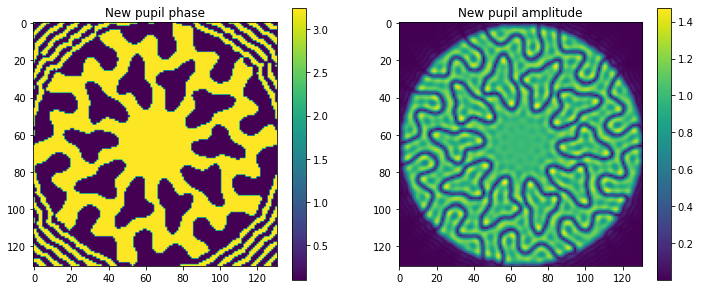

In [59]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.imshow((np.angle(pupil_smooth[:size_out, :size_out]) + 0.1)%(2*np.pi))
plt.colorbar()
plt.title("New pupil phase")

plt.subplot(1, 2, 2)
plt.imshow(np.abs(pupil_smooth[:size_out, :size_out]))
plt.colorbar()
plt.title("New pupil amplitude")

plt.show()

In [60]:
pupil_out_1 = pupil_smooth[:size_out, :size_out]

### As we can see this method has NO effect on the phase of the pupil, and simply zeros the power at the regions where the pupil phase switches from 0 to pi

In [65]:
args = {
    'image': None,
    'pupil': pupil_out_1,
    'aperture': aperture,
    'npix': npix,
    'wl': wl,
    'fl': fl,
    'pix_size': pix_size,
    'tf_size': tf_size,
    'size': size_out,
}

PSF_new_1 = JAX_model(0, 0, args=args)
OTF_new_1 = np.abs(np.fft.fftshift(np.fft.fft2(PSF_new_1)))

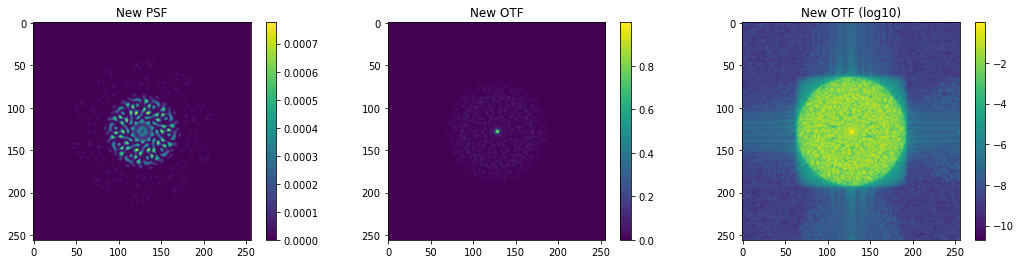

In [67]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.imshow(PSF_new_1)
plt.title("New PSF")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(OTF_new_1)
plt.title("New OTF")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.log10(OTF_new_1))
plt.title("New OTF (log10)")
plt.colorbar()

plt.show()

## This method seems to leave the PSF mostly in tact and reduces the power outside the OTF - Note there appears to be a box around the OTF now that was not there before...

---

## Method 2: Smooth the pupil with a boxcar function

In [31]:
boxcar_size = 3
boxcar = index_update(np.zeros([size_out, size_out]), index[:boxcar_size, :boxcar_size], np.ones([boxcar_size, boxcar_size]))
boxcar = boxcar/np.sum(boxcar)

In [32]:
pupil_FT = np.fft.fft2(pupil)
boxcar_FT = np.fft.fft2(boxcar)
convolved = np.fft.ifft2(pupil_FT * boxcar_FT)

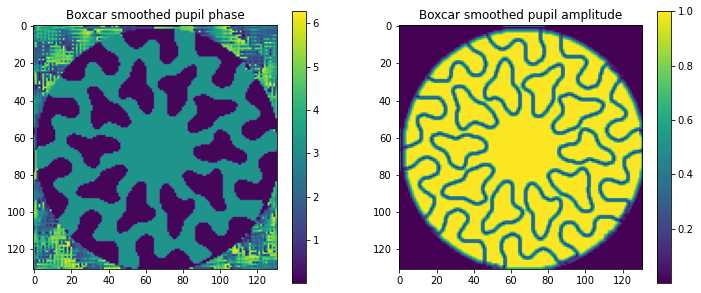

In [33]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.imshow((np.angle(convolved) + 0.1)%(2*np.pi))
plt.colorbar()
plt.title("Boxcar smoothed pupil phase")

plt.subplot(1, 2, 2)
plt.imshow(np.abs(convolved))
plt.colorbar()
plt.title("Boxcar smoothed pupil amplitude")

plt.show()

### As we can see this has the exact same effect as the first method, so now we will try smoothing the phase and amplitude seperately

In [35]:
phase_FT = np.fft.fft2(np.angle(pupil))
ampl_FT = np.fft.fft2(np.abs(pupil))
boxcar_FT = np.fft.fft2(boxcar)
convolved_phase = np.fft.ifft2(phase_FT * boxcar_FT)
convolved_ampl = np.fft.ifft2(ampl_FT * boxcar_FT)

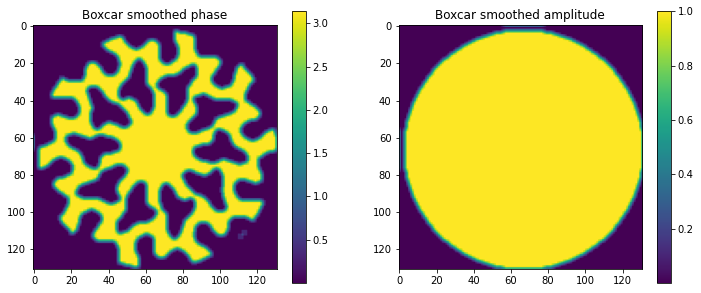

In [36]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(convolved_phase))
plt.colorbar()
plt.title("Boxcar smoothed phase")

plt.subplot(1, 2, 2)
plt.imshow(np.abs(convolved_ampl))
plt.colorbar()
plt.title("Boxcar smoothed amplitude")

plt.show()

### Lets turn this into a second new pupil and see how it affects the PSF/OTF

In [37]:
pupil_out_2 = convolved_ampl * np.exp(1j * convolved_phase)

In [43]:
args = {
    'image': None,
    'pupil': pupil_out_2,
    'aperture': aperture,
    'npix': npix,
    'wl': wl,
    'fl': fl,
    'pix_size': pix_size,
    'tf_size': tf_size,
    'size': size_out,
}

PSF_new_2 = JAX_model(0, 0, args=args)
OTF_new_2 = np.abs(np.fft.fft2(PSF_new_2))

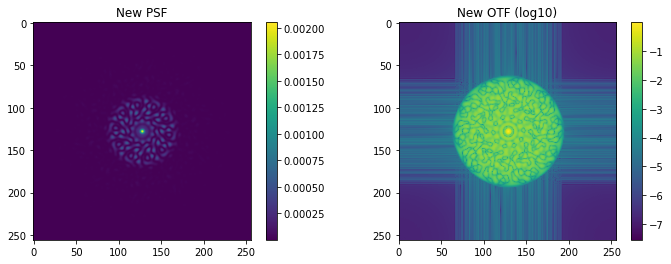

In [45]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(PSF_new_2)
plt.title("New PSF")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log10(np.fft.fftshift(OTF_new_2)))
plt.title("New OTF (log10)")
plt.colorbar()

plt.show()

## Clearly this has no effect on the OTF and also degrades the PSF